# 强化学习与组合优化

In [2]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## 强化学习试点

In [1]:
import numpy as np
import random

# 环境设置
# 图的邻接矩阵 (0 表示无连接，其他数值为路径长度)
graph = np.array([
    [0, 1, 4, 0, 0],
    [1, 0, 2, 6, 0],
    [4, 2, 0, 3, 0],
    [0, 6, 3, 0, 1],
    [0, 0, 0, 1, 0]
])

# 状态和动作
states = list(range(len(graph)))  # 5个节点
actions = list(range(len(graph)))  # 每个节点都可能是目标

# 强化学习参数
alpha = 0.1  # 学习率
gamma = 0.9  # 折扣因子
epsilon = 0.1  # ε-贪心策略

# 初始化 Q 表
q_table = np.zeros((len(states), len(actions)))

# 贪心法求解最短路径
def greedy_path(graph, start, end):
    """通过贪心法寻找从 start 到 end 的路径"""
    path = [start]
    current = start
    while current != end:
        # 找到邻接节点中未访问的最短路径
        neighbors = [(i, graph[current][i]) for i in range(len(graph)) if graph[current][i] > 0 and i not in path]
        if not neighbors:  # 无法继续
            break
        next_node = min(neighbors, key=lambda x: x[1])[0]
        path.append(next_node)
        current = next_node
    return path if current == end else None

# 强化学习训练
episodes = 1000
for episode in range(episodes):
    # 随机初始化状态
    state = random.choice(states)
    
    while True:
        # ε-贪心策略选择动作
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)
        else:
            action = np.argmax(q_table[state])
        
        # 执行动作，调用组合优化模块
        next_state = action
        path = greedy_path(graph, state, next_state)
        reward = -len(path) if path else -100  # 奖励与路径长度相关，失败时负奖励
        
        # 更新 Q 表
        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )
        
        # 跳到下一个状态
        state = next_state
        if path or episode == episodes - 1:  # 路径成功或最后一轮终止
            break

# 测试训练结果
start_node = 0
end_node = 4
best_action = np.argmax(q_table[start_node])
final_path = greedy_path(graph, start_node, best_action)

print("Q-Table:")
print(q_table)
print(f"从节点 {start_node} 到节点 {end_node} 的最优路径（近似）：{final_path}")


Q-Table:
[[ -6.18952882  -6.21377257  -6.27983692  -6.43891613  -6.18531667]
 [ -6.67868347  -6.58718743  -6.74343099  -6.96179237  -6.77658175]
 [ -6.65655226  -6.66619236  -6.68787009 -42.05815043 -59.07371039]
 [-41.46049346 -42.20751982 -63.41232397  -7.55099909  -7.53539129]
 [ -6.94449349  -6.79648839  -6.91389189  -6.96919971  -6.7792681 ]]
从节点 0 到节点 4 的最优路径（近似）：[0, 1, 2, 3, 4]


多臂老虎机试点

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# 设置随机种子
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# 定义老虎机环境
class KArmedBandit:
    def __init__(self, k):
        self.k = k
        self.q_star = np.random.normal(0, 1, k)  # 每个老虎机的真实平均奖励
    
    def step(self, action):
        """执行动作（选择一个老虎机）并返回奖励"""
        return np.random.normal(self.q_star[action], 1)  # 奖励服从N(q_star[action], 1)

# 定义DQN网络
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x):
        return self.fc(x)

# 参数和超参数
k = 10  # 10臂老虎机
episodes = 1000
gamma = 0.99
epsilon = 0.1
epsilon_decay = 0.995
min_epsilon = 0.01
learning_rate = 0.001
batch_size = 32
memory_size = 10000

# 初始化环境和DQN
env = KArmedBandit(k)
dqn = DQN(input_size=k, output_size=k)
target_dqn = DQN(input_size=k, output_size=k)
target_dqn.load_state_dict(dqn.state_dict())  # 初始化目标网络
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# 经验回放存储
def store_transition(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# 采样经验回放
def sample_batch():
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        torch.tensor(states, dtype=torch.float32),
        torch.tensor(actions, dtype=torch.int64),
        torch.tensor(rewards, dtype=torch.float32),
        torch.tensor(next_states, dtype=torch.float32),
        torch.tensor(dones, dtype=torch.float32),
    )

# 训练过程
rewards_history = []

for episode in range(episodes):
    state = np.zeros(k)  # 状态初始化为0（无实际状态）
    total_reward = 0

    for step in range(1):
        # 选择动作（ε-贪心）
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(k))
        else:
            with torch.no_grad():
                q_values = dqn(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action = torch.argmax(q_values).item()
        
        # 执行动作并获取奖励
        reward = env.step(action)
        next_state = np.zeros(k)  # 状态仍然是0（简化）
        done = True  # 单步任务，直接结束

        # 记录经验
        store_transition(state, action, reward, next_state, done)

        # 累计奖励
        total_reward += reward

        # 状态更新
        state = next_state

        # 更新网络
        if len(memory) >= batch_size:
            states, actions, rewards, next_states, dones = sample_batch()

            # 计算目标值
            with torch.no_grad():
                next_q_values = target_dqn(next_states)
                max_next_q_values = torch.max(next_q_values, dim=1)[0]
                target = rewards + gamma * max_next_q_values * (1 - dones)

            # 计算当前 Q 值
            q_values = dqn(states)
            q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

            # 计算损失并优化
            loss = nn.MSELoss()(q_values, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 目标网络软更新
        if episode % 10 == 0:
            target_dqn.load_state_dict(dqn.state_dict())

    # 更新ε
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    rewards_history.append(total_reward)

    # 打印训练进度
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

# 测试DQN
with torch.no_grad():
    state = np.zeros(k)
    q_values = dqn(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
    best_action = torch.argmax(q_values).item()

print("\n测试结果：")
print(f"每个老虎机的真实奖励均值: {env.q_star}")
print(f"学到的最佳动作: {best_action}, 真实均值: {env.q_star[best_action]:.2f}")


C:\Users\86198\AppData\Local\Temp\ipykernel_12312\4245006009.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  torch.tensor(states, dtype=torch.float32),


Episode 100/1000, Total Reward: 1.45, Epsilon: 0.06
Episode 200/1000, Total Reward: 5.38, Epsilon: 0.04
Episode 300/1000, Total Reward: 1.32, Epsilon: 0.02
Episode 400/1000, Total Reward: 2.04, Epsilon: 0.01
Episode 500/1000, Total Reward: 0.69, Epsilon: 0.01
Episode 600/1000, Total Reward: 3.02, Epsilon: 0.01
Episode 700/1000, Total Reward: 3.22, Epsilon: 0.01
Episode 800/1000, Total Reward: 0.63, Epsilon: 0.01
Episode 900/1000, Total Reward: 3.69, Epsilon: 0.01
Episode 1000/1000, Total Reward: 0.99, Epsilon: 0.01

测试结果：
每个老虎机的真实奖励均值: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
学到的最佳动作: 3, 真实均值: 1.52


## 组合优化试点

### 定义一些常量

In [ ]:
cost_battery = [ 10, -5, 3] #单位时间内的耗电量,分别是dispatching, charging, idling


### 定义车辆与订单

定义汽车

In [ ]:
import numpy as np

# 定义车辆类
class Vehicle:
    def __init__(self, data, orders):
        """
        初始化车辆信息
        data: 一个长度为10的 numpy 数组
        orders: 一个字典，键为订单主码，值为 Order 实例
        """
        self.data = data
        self.orders = orders  # 直接管理订单对象, 是一个字典
    
    def get_id(self):
        """获取车辆编号"""
        return self.data[0]
    
    def get_time(self):
        """获取当前时间"""
        return self.data[1]
    
    def update_time(self):
        """更新时间到 t+1"""
        self.data[1] += 1
    
    def get_location(self):
        """获取当前位置，城市内为 False"""
        return self.data[2] != 0
    
    def into_city(self):
        """进入城市"""
        self.data[2] = 0
    
    def intercity(self, v):
        """离开城市，前往城市 v"""
        self.data[2] = self.data[3]
        self.data[3] = v
    
    def update_state(self, decision):
        """更新决策,
        dispacthing: 0
        charging: 1
        idle: 2     """
        self.data[4] = decision
    
    def get_state(self):
        """获取当前决策"""
        return self.data[4]
    
    def update_battery(self):
        """更新电量"""
        self.data[5] -= cost_battery[self.data[4]]
    
    def get_battery(self):
        """获取电量"""
        return self.data[5]
    
    def get_orders(self):
        """获取所有订单对象"""
        return list(self.orders.values())
    
    def delete_order(self, order_id):
        """删除订单"""
        if order_id in self.orders:
            del self.orders[order_id]
    
    def add_order(self,order):
        """增加订单"""
        self.orders[order.get_id()] = order
    
    def get_capacity(self):
        """计算总载客数"""
        return sum(order.get_passenger() for order in self.orders.values())


定义订单

In [12]:
import numpy as np

class Order:
    def __init__(self, order_id, passenger_count, departure, destination, start_time, end_time, virtual_departure):
        # 使用 NumPy 数组存储属性
        self.data = np.array([
            order_id,             # ID
            passenger_count,      # 乘客数
            departure,            # 出发地
            destination,          # 目的地
            start_time,           # 起始时间
            end_time,             # 截止时间
            virtual_departure,    # 虚拟出发点
            0                     # 是否匹配 (0 表示 False, 1 表示 True)
        ], dtype=object)

    def get_id(self):
        """返回订单 ID"""
        return self.data[0]

    def get_passenger(self):
        """返回订单乘客数"""
        return self.data[1]

    def get_route(self):
        """返回出发地和目的地"""
        return self.data[2], self.data[3]

    def get_time(self):
        """获取起始与截止时间"""
        return self.data[4], self.data[5]

    def change_virtual_departure(self, virtual_departure):
        """改变虚拟出发点"""
        self.data[6] = virtual_departure

    def be_matched(self):
        """被匹配"""
        self.data[7] = 1 


汽车与订单的互动

In [14]:
def vehicle_match_order(vehicle, order):
    """车辆匹配订单"""
    order.be_matched()
    vehicle.add_order(order.get_id())


### 定义城市与图

生成图

In [35]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def create_random_directed_graph(num_nodes, edge_prob, weight_range=(1, 10)):
    """
    创建一个随机有向图并生成随机边的权重。
    
    参数:
        num_nodes: 节点数量
        edge_prob: 每两个节点之间存在边的概率（0 到 1）
        weight_range: 权重范围，默认为 (1, 10)
    
    返回:
        G: 随机有向图 (DiGraph)
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for u in range(num_nodes):
        for v in range(num_nodes):
            if u != v and random.random() < edge_prob:
                weight = random.randint(*weight_range)
                G.add_edge(u, v, weight=weight)
    return G

def visualize_graph(G, figsize=(10, 8)):
    """
    可视化有向图。
    
    参数:
        G: 有向图 (DiGraph)
        figsize: 画布大小，默认为 (10, 8)
    """
    plt.figure(figsize=figsize)  # 调整画布大小
    pos = nx.spring_layout(G)  # 使用 spring 布局
    edge_labels = nx.get_edge_attributes(G, 'weight')  # 获取边的权重
    
    # 绘制图
    nx.draw(
        G, pos, with_labels=True, node_size=1000, node_color="lightblue", 
        font_size=12, font_weight="bold", arrowsize=20
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=10)
    
    plt.title("Random Directed Graph", fontsize=16)
    plt.show()

def extract_graph_info(G):
    """
    提取图的节点、边及权重信息。
    
    参数:
        G: 有向图 (DiGraph)
    
    返回:
        nodes: 节点列表
        edges: 边列表
        weights: 边权重字典
    """
    nodes = list(G.nodes())
    edges = list(G.edges())
    weights = nx.get_edge_attributes(G, 'weight')
    return nodes, edges, weights



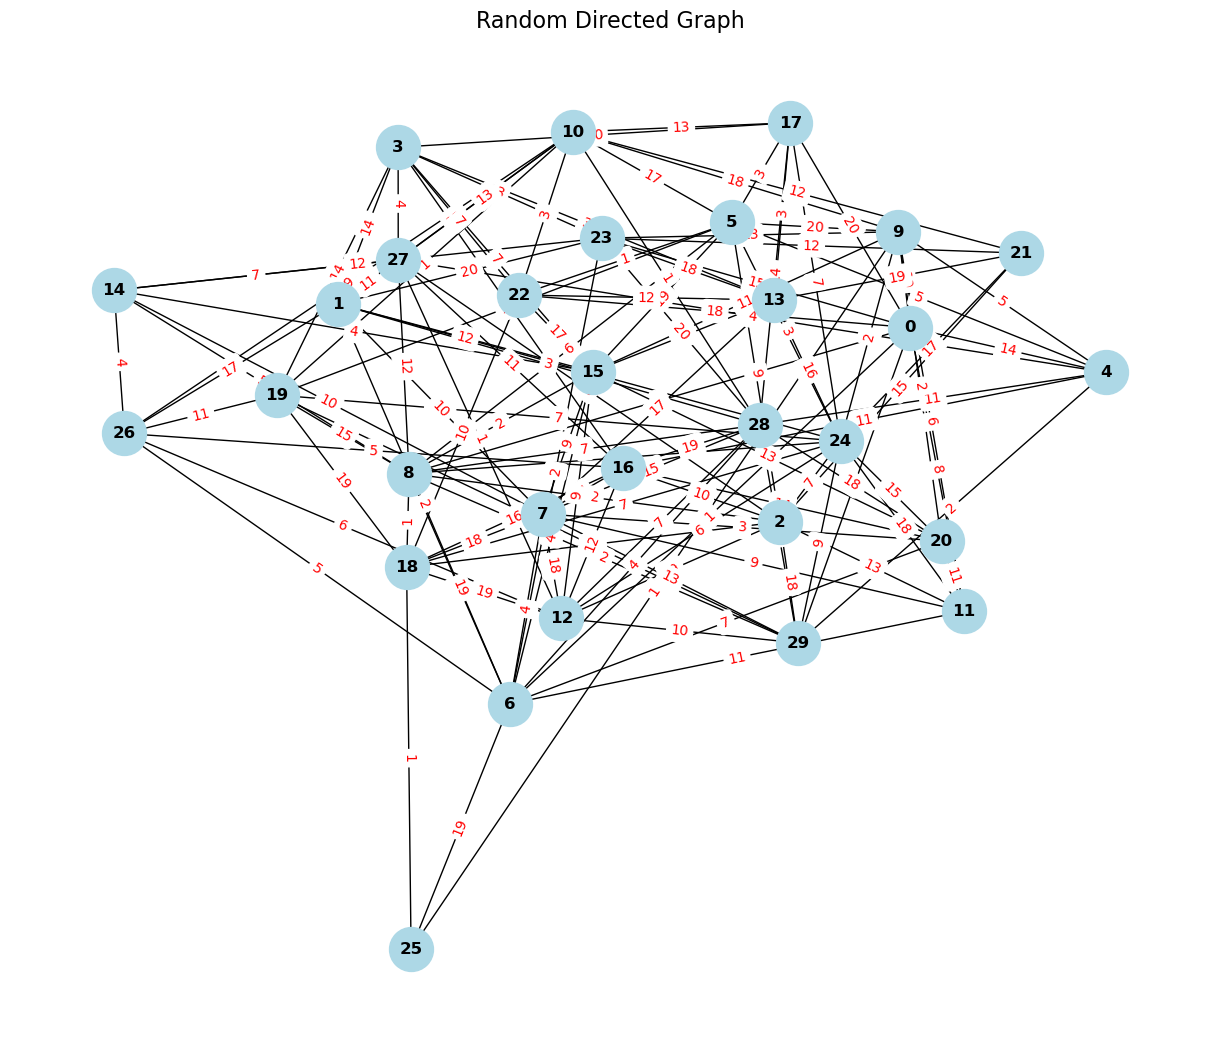

Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Edges: [(0, 4), (0, 6), (0, 8), (0, 9), (0, 11), (0, 17), (0, 22), (0, 23), (0, 29), (1, 3), (1, 15), (1, 24), (1, 26), (1, 28), (1, 6), (1, 7), (1, 10), (1, 23), (1, 27), (2, 8), (2, 11), (2, 18), (2, 21), (2, 24), (2, 27), (2, 5), (2, 12), (2, 16), (2, 29), (3, 13), (3, 16), (3, 17), (3, 19), (3, 22), (3, 27), (3, 15), (3, 23), (4, 29), (4, 5), (4, 9), (4, 16), (4, 27), (4, 28), (5, 8), (5, 9), (5, 15), (5, 17), (5, 19), (5, 24), (5, 10), (5, 22), (6, 8), (6, 25), (6, 26), (6, 7), (6, 11), (6, 15), (6, 20), (6, 23), (6, 28), (7, 13), (7, 15), (7, 16), (7, 18), (7, 20), (7, 11), (7, 12), (7, 14), (7, 28), (7, 29), (8, 14), (8, 18), (8, 19), (8, 24), (8, 27), (8, 28), (8, 29), (8, 15), (9, 10), (9, 11), (9, 23), (9, 15), (9, 20), (9, 24), (9, 25), (10, 17), (10, 19), (10, 21), (10, 22), (10, 27), (10, 26), (10, 28), (11, 20), (11, 24), (12, 18), (12, 24), (12, 28), (12,

In [43]:
# 示例：创建并绘制图，同时提取信息
num_nodes = 30
edge_prob = 0.2
weight_range = (1, 20)

G = create_random_directed_graph(num_nodes, edge_prob, weight_range)
visualize_graph(G, figsize=(12, 10))

nodes, edges, weights = extract_graph_info(G)

# 打印信息
print("Nodes:", nodes)
print("Edges:", edges)
print("Weights:", weights)

#### 使用Dijkstra算法存储最短路径

In [37]:
import networkx as nx

def calculate_shortest_paths(G):
    """
    计算图 G 中任意两节点间的最短距离和路径，返回结果。
    
    Args:
    - G (nx.Graph): 无向图。
    
    Returns:
    - results (list): 每对节点的最短路径信息，包含起点、终点、距离和经过的节点。
    """
    nodes = list(G.nodes)
    results = []
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):  # 确保无重复的城市对
            source = nodes[i]
            target = nodes[j]
            try:
                # 使用 Dijkstra 算法计算最短路径和距离
                length = nx.dijkstra_path_length(G, source, target)
                path = nx.dijkstra_path(G, source, target)
                results.append({"source": source, "target": target, "distance": length, "path": path})
            except nx.NetworkXNoPath:
                # 如果没有路径，跳过
                continue
    return results


In [38]:
G = create_random_directed_graph(num_nodes, edge_prob, weight_range)
result = calculate_shortest_paths(G)
print(result)

[{'source': 0, 'target': 1, 'distance': 2, 'path': [0, 1]}, {'source': 0, 'target': 2, 'distance': 9, 'path': [0, 6, 2]}, {'source': 0, 'target': 3, 'distance': 13, 'path': [0, 1, 3]}, {'source': 0, 'target': 4, 'distance': 14, 'path': [0, 6, 2, 4]}, {'source': 0, 'target': 5, 'distance': 8, 'path': [0, 5]}, {'source': 0, 'target': 6, 'distance': 7, 'path': [0, 6]}, {'source': 0, 'target': 7, 'distance': 11, 'path': [0, 6, 2, 7]}, {'source': 0, 'target': 8, 'distance': 22, 'path': [0, 5, 8]}, {'source': 0, 'target': 9, 'distance': 13, 'path': [0, 6, 2, 9]}, {'source': 1, 'target': 2, 'distance': 11, 'path': [1, 0, 6, 2]}, {'source': 1, 'target': 3, 'distance': 11, 'path': [1, 3]}, {'source': 1, 'target': 4, 'distance': 16, 'path': [1, 0, 6, 2, 4]}, {'source': 1, 'target': 5, 'distance': 10, 'path': [1, 0, 5]}, {'source': 1, 'target': 6, 'distance': 9, 'path': [1, 0, 6]}, {'source': 1, 'target': 7, 'distance': 13, 'path': [1, 0, 6, 2, 7]}, {'source': 1, 'target': 8, 'distance': 24, 'pat

提取Dijkstra算法的最短路径

In [ ]:
def get_shortest_path_from_result(result, source, target):
    """
    从给定的 result 列表中提取指定城市对的最短路径和距离。

    Args:
    - result (list): 预先计算的所有城市对的最短路径信息。
                     每个元素是一个字典，格式为：
                     {'source': s, 'target': t, 'distance': d, 'path': [path]}。
    - source (int): 起始城市的编号。
    - target (int): 终点城市的编号。

    Returns:
    - dict: 包含最短路径的距离和节点顺序。
            如果 source 和 target 顺序相反，则调整顺序。
            如果无路径，返回 None。
    """
    for entry in result:
        if entry['source'] == source and entry['target'] == target:
            return {'distance': entry['distance'], 'path': entry['path']}
        elif entry['source'] == target and entry['target'] == source:
            # 反向路径，调整顺序
            return {'distance': entry['distance'], 'path': list(reversed(entry['path']))}
    return None


{'distance': 13, 'path': [7, 2, 6, 0, 1]}


In [ ]:
print(get_shortest_path_from_result(result,7,1))

获取某一城市的领接城市

#### 定义城市

In [ ]:
class City:
    def __init__(self, city_id, neighbor, vehicle_available, charging_capacity, as_real_departure, as_virtual_departure):
        self.data = np.array([
            city_id,
            neighbor,
            
            charging_capacity,
            as_real_departure,
            as_virtual_departure
        ])
        self.vehicle_available = vehicle_available
    def get_neighbor(self):
        """获取城市的邻接城市"""
        return self.neighbor
    def get_vehicle_available(self):
        """获取可调度的车辆"""  
    